In [101]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt #for the plots
import OurFunctions as of
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


In [102]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif


In [103]:

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [104]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))


# CLASSIFICATION

In [105]:
def k_fold_cross_validation(features_df, target_df, classifier, scaler=None, encoder=None, k=5):
    # Separazione delle feature e del target
    X = features_df  # Utilizziamo il DataFrame delle features senza modifiche
    y = target_df['DX_GROUP']  # Utilizziamo la colonna target come y direttamente

    # Encoding delle features da numeriche a categoriche (opzionale)
    if encoder:
        X_encoded = encoder.fit_transform(X)
    else:
        X_encoded = X

    # Normalizzazione dei dati (opzionale)
    if scaler:
        X_scaled = scaler.fit_transform(X_encoded)
    else:
        X_scaled = X_encoded

    # Definizione della k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Esecuzione della k-fold cross-validation
    cv_results = cross_val_score(classifier, X_scaled, y, cv=kf, scoring='accuracy')
'''
    # Visualizzazione dei risultati
    print(f'Accuratezza per ogni fold: {cv_results}')
    print(f'Accuratezza media: {cv_results.mean()}')
    print(f'Deviazione standard dell\'accuratezza: {cv_results.std()}')
'''



"\n    # Visualizzazione dei risultati\n    print(f'Accuratezza per ogni fold: {cv_results}')\n    print(f'Accuratezza media: {cv_results.mean()}')\n    print(f'Deviazione standard dell'accuratezza: {cv_results.std()}')\n"

# K-NEAREST NEIGHBOOR

In [106]:
classifier = KNeighborsClassifier()

# Definizione delle metriche da utilizzare come scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}
# Identifica le colonne categoriche
categorical_columns = ASD_phenotypic.select_dtypes(include=['object']).columns

# Definisci il preprocessing delle colonne
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), ~ASD_phenotypic.columns.isin(categorical_columns)),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Definisci il pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


# Definizione dei parametri della griglia da esplorare
parameters = {'classifier__n_neighbors': [3, 5, 7, 9, 11]}  # Valori di n_neighbors da esplorare

k_fold_cross_validation(ASD_phenotypic, ASD_diagnosis, pipeline)

# Creazione dell'oggetto GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring=scoring, refit='accuracy')

# Esecuzione della ricerca a griglia
grid_search.fit(ASD_phenotypic, ASD_diagnosis['DX_GROUP'])

# Visualizzazione dei risultati
print("Risultati della cross-validation per tutte le combinazioni di iperparametri:")

means_accuracy = grid_search.cv_results_['mean_test_accuracy']
stds_accuracy = grid_search.cv_results_['std_test_accuracy']
means_precision = grid_search.cv_results_['mean_test_precision']
means_recall = grid_search.cv_results_['mean_test_recall']
means_f1_score = grid_search.cv_results_['mean_test_f1_score']
params = grid_search.cv_results_['params']

for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
    print(f"Parametri: {params}, Accuratezza media: {mean_acc:.3f} (±{std_acc:.3f}), Precision media: {mean_prec:.3f}, Richiamo medio: {mean_rec:.3f}, F1-score medio: {mean_f1:.3f}")

print("\nMiglior parametro trovato:")
print("Numero di vicini:", grid_search.best_params_['classifier__n_neighbors'])
print("Accuratezza media con il miglior parametro:", grid_search.best_score_)


Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_neighbors': 3}, Accuratezza media: 0.823 (±0.077), Precision media: 0.903, Richiamo medio: 0.829, F1-score medio: 0.853
Parametri: {'classifier__n_neighbors': 5}, Accuratezza media: 0.819 (±0.081), Precision media: 0.903, Richiamo medio: 0.819, F1-score medio: 0.848
Parametri: {'classifier__n_neighbors': 7}, Accuratezza media: 0.826 (±0.093), Precision media: 0.923, Richiamo medio: 0.809, F1-score medio: 0.853
Parametri: {'classifier__n_neighbors': 9}, Accuratezza media: 0.825 (±0.093), Precision media: 0.930, Richiamo medio: 0.797, F1-score medio: 0.850
Parametri: {'classifier__n_neighbors': 11}, Accuratezza media: 0.810 (±0.100), Precision media: 0.921, Richiamo medio: 0.777, F1-score medio: 0.835

Miglior parametro trovato:
Numero di vicini: 7
Accuratezza media con il miglior parametro: 0.8261362361126696


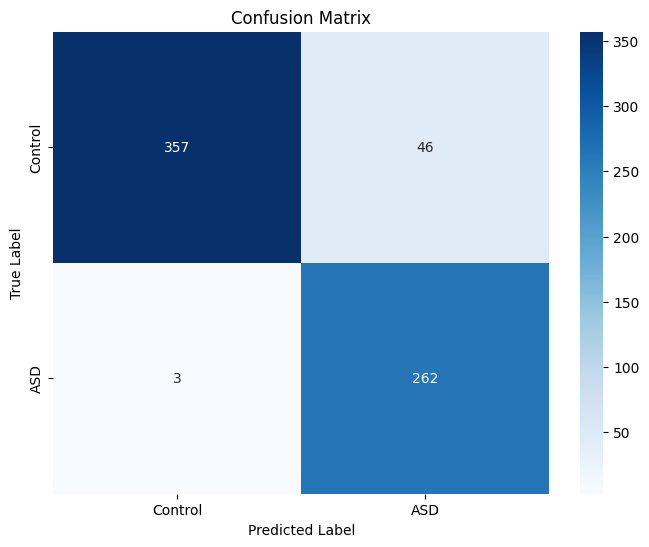

In [107]:
# Miglior modello trovato
best_model = grid_search.best_estimator_

# Calcola le previsioni del miglior modello sul set di test
y_pred = best_model.predict(ASD_phenotypic)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(ASD_diagnosis['DX_GROUP'], y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [109]:
'''
Visualizzare l'effetto del modello sui dati attraverso un grafico di decisione

# Riduzione della dimensione a 2D usando PCA (se ci sono più di due caratteristiche)
pca = PCA(n_components=2)
ASD_phenotypic_2d = pca.fit_transform(ASD_phenotypic)

# Definizione del pipeline con PCA e il miglior modello trovato
pipeline_2d = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('classifier', KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors']))
])

# Adattamento del pipeline
pipeline_2d.fit(ASD_phenotypic, ASD_diagnosis['DX_GROUP'])

# Creazione di una meshgrid per la visualizzazione delle regioni di decisione
h = .02  # passo della meshgrid
x_min, x_max = ASD_phenotypic_2d[:, 0].min() - 1, ASD_phenotypic_2d[:, 0].max() + 1
y_min, y_max = ASD_phenotypic_2d[:, 1].min() - 1, ASD_phenotypic_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predizione su ogni punto della meshgrid
Z = pipeline_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Creazione di un colormap per la visualizzazione delle regioni di decisione
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

# Visualizzazione delle regioni di decisione
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Visualizzazione dei punti di addestramento
scatter = plt.scatter(ASD_phenotypic_2d[:, 0], ASD_phenotypic_2d[:, 1], c=ASD_diagnosis['DX_GROUP'], cmap=cmap_bold, edgecolor='k', s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=['Control', 'ASD'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundaries with k-NN')
plt.show()
'''

"\nVisualizzare l'effetto del modello sui dati attraverso un grafico di decisione\n\n# Riduzione della dimensione a 2D usando PCA (se ci sono più di due caratteristiche)\npca = PCA(n_components=2)\nASD_phenotypic_2d = pca.fit_transform(ASD_phenotypic)\n\n# Definizione del pipeline con PCA e il miglior modello trovato\npipeline_2d = Pipeline([\n    ('preprocessor', preprocessor),\n    ('pca', PCA(n_components=2)),\n    ('classifier', KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors']))\n])\n\n# Adattamento del pipeline\npipeline_2d.fit(ASD_phenotypic, ASD_diagnosis['DX_GROUP'])\n\n# Creazione di una meshgrid per la visualizzazione delle regioni di decisione\nh = .02  # passo della meshgrid\nx_min, x_max = ASD_phenotypic_2d[:, 0].min() - 1, ASD_phenotypic_2d[:, 0].max() + 1\ny_min, y_max = ASD_phenotypic_2d[:, 1].min() - 1, ASD_phenotypic_2d[:, 1].max() + 1\nxx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                     np.arange(y_min, y_max, h)

## Random Forest

To use the Random Forest classifier, I need to have only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features

In [ ]:
ASD_phenotypic_encoded = of.One_hot_encoding(ASD_phenotypic)
ASD_phenotypic_encoded

First we split the data into training, validation and testing sets.

In [ ]:

# Split the dataset into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(ASD_phenotypic_encoded, ASD_diagnosis, test_size=0.2, random_state=42)

# Split the train+validation set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

I want to check the balance btw classes for each set

In [ ]:
class_counts_test = y_test.value_counts(normalize=True)
class_counts_train = y_train.value_counts(normalize=True)
class_counts_val = y_val.value_counts(normalize=True)

# Stampa il conteggio delle classi per DX_GROUP
print("Class proportions for:")
print("- test set: " + str(class_counts_test))
print("- train set: " + str(class_counts_train))
print("- val set: " + str(class_counts_val))

In [ ]:
random_clf = RandomForestClassifier(n_estimators=10)
random_clf = random_clf.fit(X_train, y_train)

In [ ]:
# Use the trained random forest classifier to predict labels for the validation set
y_pred = random_clf.predict(X_val)

# Calculate the accuracy of the classifier on the validation set
accuracy = accuracy_score(y_val, y_pred)

# Print the accuracy
print("Accuracy on the validation set:", accuracy)


In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, 
                                        y_pred)
plt.show()

In [ ]:
y_pred = random_clf.predict(X_test)

# Calculate the accuracy of the classifier on the validation set
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy on the testing set:", accuracy)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred)
plt.show()

# Logistic Regression and KNN Neighboors

In [ ]:
numeric_columns, categorical_columns, ASD_phenotypic_tot = of.select_columns(ASD_phenotypic_tot)

In [ ]:
# Separazione delle feature e del target
X = ASD_phenotypic_tot.drop(columns=['DX_GROUP'])
y = ASD_phenotypic_tot['DX_GROUP']

# Pipeline di preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Modelli
models = {
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression()
}

# Selezione delle feature e valutazione del modello
def evaluate_model(X, y, model, k_features):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k_features)),
        ('classifier', model)
    ])
    
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    return scores.mean()

# Valutazione dei modelli con diverse selezioni di feature
results = {}
for model_name, model in models.items():
    best_score = 0
    best_k = 0
    for k in range(1, len(X.columns) + 1):
        score = evaluate_model(X, y, model, k)
        if score > best_score:
            best_score = score
            best_k = k
    results[model_name] = {'best_k': best_k, 'best_score': best_score}

print(results)